## Insurance Price Prediction

In [3]:
from sklearn.linear_model import LinearRegression,Lasso
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures,LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
insurance_df = pd.read_csv('insurance.csv')

In [5]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
insurance_df.shape

(1338, 7)

In [7]:
insurance_df.select_dtypes('number').corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


**Function to check different relationship between values in categorical feature and charges**

In [8]:
def target_categorical_feature_relation(df,col):
    print(f"Value counts for different values in {col}")
    display(df[col].value_counts())
    print(f"Mean of different values in {col} with charges")
    display(df.groupby(col)['charges'].mean())
    print(f"Median of different values in {col} with charges")
    display(df.groupby(col)['charges'].median())

In [9]:
target_categorical_feature_relation(insurance_df,'sex')

Value counts for different values in sex


sex
male      676
female    662
Name: count, dtype: int64

Mean of different values in sex with charges


sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

Median of different values in sex with charges


sex
female    9412.96250
male      9369.61575
Name: charges, dtype: float64

Findings: From the above we can assume that there is no signifcance difference in different values for gender with charges. Means both Male and female consider equally

There is no ordinal relationship between sex and target, so we can use OneHotEncode

In [10]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = one_hot_encoder.fit_transform(insurance_df[['sex']])

In [11]:
sex_encoded

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [12]:
sex_cols_names = one_hot_encoder.get_feature_names_out()

In [13]:
sex_encoded_df = pd.DataFrame(sex_encoded,columns=sex_cols_names)
sex_encoded_df

,sex_female,sex_male
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
1333,0.0,1.0
1334,1.0,0.0
1335,1.0,0.0
1336,1.0,0.0


In [14]:
insurance_df1 = pd.concat([sex_encoded_df,insurance_df],axis=1)
insurance_df2 = insurance_df1.drop('sex',axis=1)

In [15]:
insurance_df2

,sex_female,sex_male,age,bmi,children,smoker,region,charges
0,1.0,0.0,19,27.900,0,yes,southwest,16884.92400
1,0.0,1.0,18,33.770,1,no,southeast,1725.55230
2,0.0,1.0,28,33.000,3,no,southeast,4449.46200
3,0.0,1.0,33,22.705,0,no,northwest,21984.47061
4,0.0,1.0,32,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,0.0,1.0,50,30.970,3,no,northwest,10600.54830
1334,1.0,0.0,18,31.920,0,no,northeast,2205.98080
1335,1.0,0.0,18,36.850,0,no,southeast,1629.83350
1336,1.0,0.0,21,25.800,0,no,southwest,2007.94500


In [16]:
target_categorical_feature_relation(insurance_df2,'smoker')

Value counts for different values in smoker


smoker
no     1064
yes     274
Name: count, dtype: int64

Mean of different values in smoker with charges


smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

Median of different values in smoker with charges


smoker
no      7345.40530
yes    34456.34845
Name: charges, dtype: float64

We can see that there is a relationship between smokers and charges. Charge for smokers is significantly higher than charge for non smokers. So we can perform labelencode here(n=0,y=1)

In [17]:
label_encoder = LabelEncoder()
insurance_df2['smoker'] = label_encoder.fit_transform(insurance_df2['smoker'])

In [18]:
insurance_df2

,sex_female,sex_male,age,bmi,children,smoker,region,charges
0,1.0,0.0,19,27.900,0,1,southwest,16884.92400
1,0.0,1.0,18,33.770,1,0,southeast,1725.55230
2,0.0,1.0,28,33.000,3,0,southeast,4449.46200
3,0.0,1.0,33,22.705,0,0,northwest,21984.47061
4,0.0,1.0,32,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,0.0,1.0,50,30.970,3,0,northwest,10600.54830
1334,1.0,0.0,18,31.920,0,0,northeast,2205.98080
1335,1.0,0.0,18,36.850,0,0,southeast,1629.83350
1336,1.0,0.0,21,25.800,0,0,southwest,2007.94500


In [19]:
target_categorical_feature_relation(insurance_df2,'region')

Value counts for different values in region


region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Mean of different values in region with charges


region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

Median of different values in region with charges


region
northeast    10057.652025
northwest     8965.795750
southeast     9294.131950
southwest     8798.593000
Name: charges, dtype: float64

We can`t see an ordinal relationship here, so we need to use Onehotencode

In [20]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
region_encoded = one_hot_encoder.fit_transform(insurance_df2[['region']])
region_encoded

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [21]:
region_feature = one_hot_encoder.get_feature_names_out()
region_feature

array(['region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [22]:
region_df = pd.DataFrame(region_encoded,columns=region_feature)
region_df.head()

,region_northeast,region_northwest,region_southeast,region_southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [23]:
insurance_df3 = pd.concat([region_df,insurance_df2],axis=1)
insurance_df3.head()
insurance_df4 = insurance_df3.drop('region',axis=1)

In [24]:
insurance_df4.head(3)

,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,age,bmi,children,smoker,charges
0,0.0,0.0,0.0,1.0,1.0,0.0,19,27.90,0,1,16884.9240
1,0.0,0.0,1.0,0.0,0.0,1.0,18,33.77,1,0,1725.5523
2,0.0,0.0,1.0,0.0,0.0,1.0,28,33.00,3,0,4449.4620


In [25]:
insurance_df4.corr()

,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,age,bmi,children,smoker,charges
region_northeast,1.000000,-0.320177,-0.345561,-0.320177,0.002425,-0.002425,0.002475,-0.138156,-0.022808,0.002811,0.006349
region_northwest,-0.320177,1.000000,-0.346265,-0.320829,0.011156,-0.011156,-0.000407,-0.135996,0.024806,-0.036945,-0.039905
region_southeast,-0.345561,-0.346265,1.000000,-0.346265,-0.017117,0.017117,-0.011642,0.270025,-0.023066,0.068498,0.073982
region_southwest,-0.320177,-0.320829,-0.346265,1.000000,0.004184,-0.004184,0.010016,-0.006205,0.021914,-0.036945,-0.043210
sex_female,0.002425,0.011156,-0.017117,0.004184,1.000000,-1.000000,0.020856,-0.046371,-0.017163,-0.076185,-0.057292
sex_male,-0.002425,-0.011156,0.017117,-0.004184,-1.000000,1.000000,-0.020856,0.046371,0.017163,0.076185,0.057292
age,0.002475,-0.000407,-0.011642,0.010016,0.020856,-0.020856,1.000000,0.109272,0.042469,-0.025019,0.299008
bmi,-0.138156,-0.135996,0.270025,-0.006205,-0.046371,0.046371,0.109272,1.000000,0.012759,0.003750,0.198341
children,-0.022808,0.024806,-0.023066,0.021914,-0.017163,0.017163,0.042469,0.012759,1.000000,0.007673,0.067998
smoker,0.002811,-0.036945,0.068498,-0.036945,-0.076185,0.076185,-0.025019,0.003750,0.007673,1.000000,0.787251


In [26]:
X,y = insurance_df4.drop('charges',axis=1),insurance_df4['charges']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

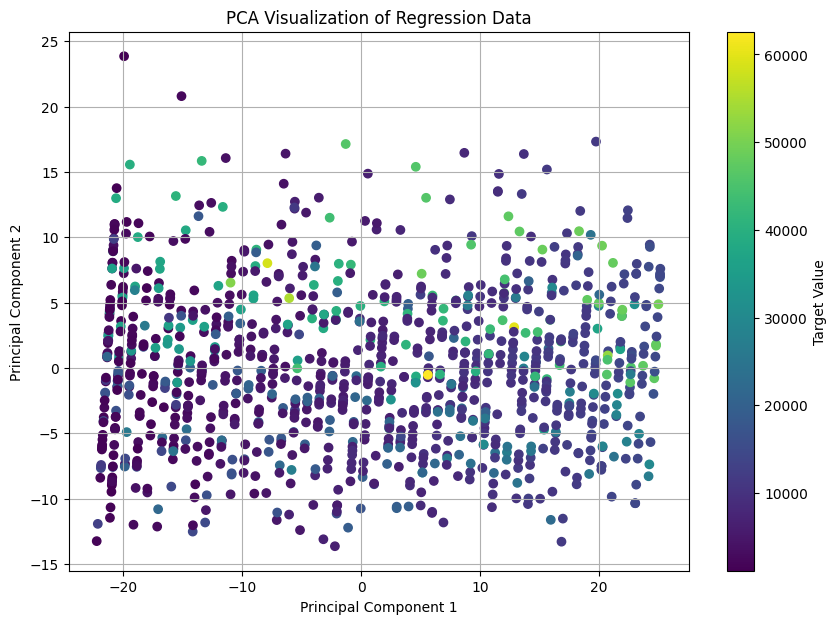

In [29]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.colorbar(scatter, label='Target Value')
plt.title('PCA Visualization of Regression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

From the above visualization using pca and also correlation we can`t see a linear relationship between target(charges) and features

Linear Regression

In [30]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled,y_train)
linear_model.score(X_train_scaled,y_train)

0.7407866421941036

Polynomial Regression

In [31]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [32]:
X_train_poly.shape

(1070, 56)

In [33]:
poly_model = LinearRegression()
poly_model.fit(X_train_poly,y_train)
poly_model.score(X_train_poly,y_train)

0.8365346276896324

Lasso Regression

In [34]:
lasso = Lasso()
lasso.fit(X_train_scaled,y_train)
lasso.score(X_train_scaled,y_train)

0.7417255335575172

Support Vector Regression

In [35]:
svr = SVR()
svr.fit(X_train_scaled,y_train)
svr.score(X_train_scaled,y_train)

-0.09521624640845139

In [36]:
# from sklearn.model_selection import GridSearchCV 
  
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#               'kernel': ['rbfd']}  
  
# grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 
  
# grid.fit(X_train_scaled, y_train)
# print(grid.best_params_) 

# print(grid.best_estimator_) 

**Hyperparameter tuned SVR**

In [37]:
svr = SVR(C=1000, gamma=0.1)
svr.fit(X_train_scaled,y_train)
svr.score(X_train_scaled,y_train)

0.6863708265251509

In [38]:
def evaluate(model,data):
    pred = model.predict(data)
    display(type(model).__name__)
    display(mean_squared_error(y_test,pred))
    display(mean_absolute_error(y_test,pred))
    display(np.sqrt(mean_squared_error(y_test,pred)))
    display(r2_score(y_test,pred))

In [39]:
evaluate(linear_model,X_test_scaled)

'LinearRegression'

33888104.87443317

4212.991673364193

5821.349059662473

0.7817173477116052

In [40]:
evaluate(poly_model,X_test_poly)

'LinearRegression'

21146288.07309838

2636.561803914179

4598.509331631108

0.8637909123642733

In [41]:
evaluate(lasso,X_test_scaled)

'Lasso'

33600484.70509693

4181.37638381455

5796.592508111721

0.7835699887385077

In [42]:
evaluate(svr,X_test_scaled)

'SVR'

44911863.75299982

3063.658097179309

6701.63142473531

0.7107102691181753

**Ensemble Techniques**

In [43]:
adaboost = AdaBoostRegressor()
adaboost.fit(X_train,y_train)
adaboost.score(X_train,y_train)

0.8374046446588248

In [44]:
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(X_train,y_train)
gradient_boost.score(X_train,y_train)

0.8997306137069336

In [45]:
xgboost = XGBRegressor()
xgboost.fit(X_train,y_train)
xgboost.score(X_train,y_train)

0.9945325247556726

In [46]:
evaluate(adaboost,X_test)

'AdaBoostRegressor'

26762889.283214875

4025.9432519256334

5173.286120370192

0.8276128311899732

In [47]:
evaluate(gradient_boost,X_test)

'GradientBoostingRegressor'

18789600.257307447

2410.572336081275

4334.697250940076

0.8789709901217254

In [48]:
evaluate(xgboost,X_test)

'XGBRegressor'

23420566.274012674

2675.916374019752

4839.479959046496

0.8491416577194145